# Full Pipeline Evaluation & Analysis

This notebook breaks down the tooth detection pipeline into its 3 stages to analyze performance and identify failure points.

**Stages:**
1.  **Quadrant Detection:** Locating the 4 dental quadrants.
2.  **Tooth Detection:** Detecting individual teeth within the image.
3.  **Disease Classification:** Classifying each tooth/crop for diseases.

In [20]:
import cv2
import os
import sys
import glob
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np

# Add src to path to import config if needed, though we will explicitly define paths here for clarity
sys.path.append('../src')

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

MODEL_PATHS = {
    "stage1": "../models/stage1_n_640/train/weights/best.pt",
    "stage2": "../models/stage2_m_640/weights/best.pt",
    "stage3": "../models/stage3_m_224_cls/weights/best.pt"
}

In [21]:
def load_models():
    models = {}
    for key, path in MODEL_PATHS.items():
        if os.path.exists(path):
            print(f"Loading {key}: {path}")
            models[key] = YOLO(path)
        else:
            print(f"MISSING: {path}")
    return models

models = load_models()

Loading stage1: ../models/stage1_n_640/train/weights/best.pt
Loading stage2: ../models/stage2_m_640/weights/best.pt
Loading stage3: ../models/stage3_m_224_cls/weights/best.pt


In [22]:
def visualize_boxes(img, boxes, color=(0, 255, 0), label_prefix=""):
    img_vis = img.copy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        conf = box.conf[0].item()
        cls = int(box.cls[0].item())
        label = f"{label_prefix}{cls} {conf:.2f}"
        
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), color, 3)
        cv2.putText(img_vis, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img_vis

def pipeline_inference(img_path, models):
    img = cv2.imread(img_path)
    if img is None: 
        print(f"Could not load {img_path}")
        return None
        
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = {}
    
    # Stage 1: Quadrants
    s1_res = models['stage1'].predict(img, conf=0.25, verbose=False)[0]
    results['stage1'] = s1_res
    
    # Stage 2: Teeth
    s2_res = models['stage2'].predict(img, conf=0.25, verbose=False)[0]
    results['stage2'] = s2_res
    
    # Stage 3: Disease (on teeth crops)
    diseases = []
    for box in s2_res.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        crop = img[max(0,y1):min(img.shape[0],y2), max(0,x1):min(img.shape[1],x2)]
        if crop.size == 0: continue
        
        s3_res = models['stage3'].predict(crop, verbose=False)[0]
        
        disease_id = s3_res.probs.top1
        disease_name = s3_res.names[disease_id]
        conf = s3_res.probs.top1conf.item()
        
        diseases.append({
            'box': [x1, y1, x2, y2],
            'name': disease_name,
            'conf': conf
        })
        
    results['stage3'] = diseases
    results['img'] = img_rgb
    return results

In [23]:
# Get validation images
val_images = glob.glob('../data/raw/val/validation_data/quadrant_enumeration_disease/xrays/*.png')
val_images.sort()
print(f"Found {len(val_images)} validation images.")

# Select a few samples (e.g., first 3)
samples = val_images[:3]
if '../data/raw/val/validation_data/quadrant_enumeration_disease/xrays/val_1.png' in val_images:
    # Ensure val_1 is included as requested
    samples = ['../data/raw/val/validation_data/quadrant_enumeration_disease/xrays/val_1.png'] + val_images[:2]
    samples = list(set(samples)) # Deduplicate

Found 50 validation images.


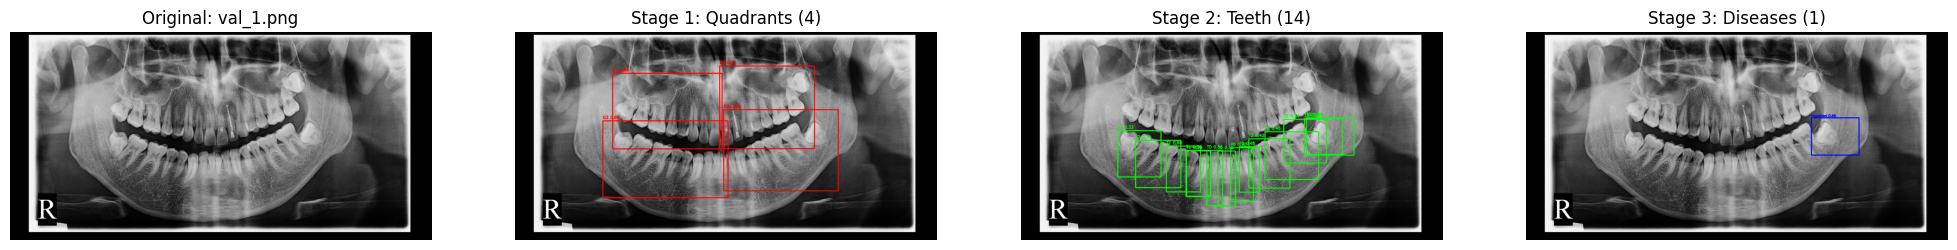

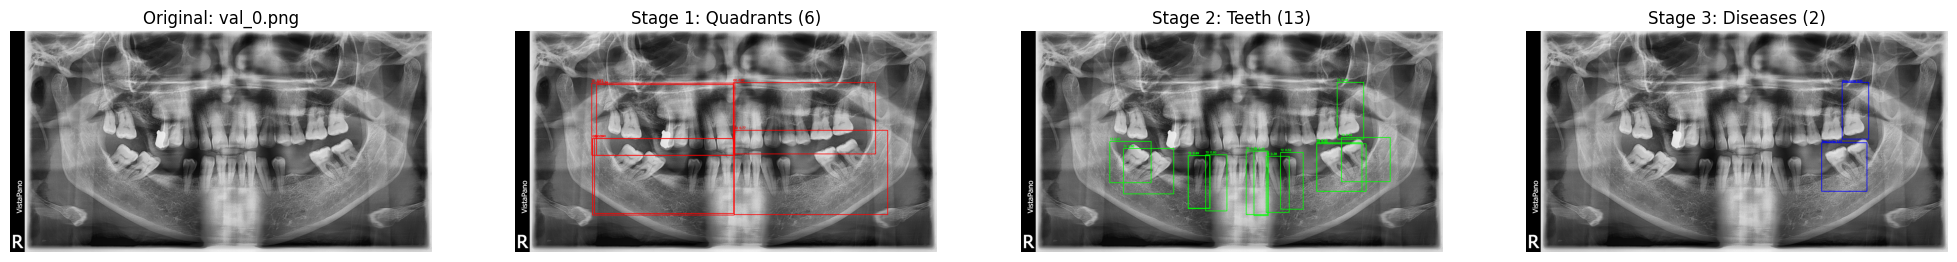

In [24]:
for img_path in samples:
    res = pipeline_inference(img_path, models)
    if not res: continue
    
    fig, axs = plt.subplots(1, 4, figsize=(25, 6))
    
    # Original
    axs[0].imshow(res['img'])
    axs[0].set_title(f"Original: {os.path.basename(img_path)}")
    axs[0].axis('off')
    
    # Stage 1: Quadrants
    img_s1 = visualize_boxes(res['img'], res['stage1'].boxes, color=(255, 0, 0), label_prefix="Q")
    axs[1].imshow(img_s1)
    axs[1].set_title(f"Stage 1: Quadrants ({len(res['stage1'].boxes)})")
    axs[1].axis('off')
    
    # Stage 2: Teeth
    img_s2 = visualize_boxes(res['img'], res['stage2'].boxes, color=(0, 255, 0), label_prefix="T")
    axs[2].imshow(img_s2)
    axs[2].set_title(f"Stage 2: Teeth ({len(res['stage2'].boxes)})")
    axs[2].axis('off')
    
    # Stage 3: Diseases
    img_s3 = res['img'].copy()
    count = 0
    for d in res['stage3']:
        if d['name'] == 'Healthy': continue
        
        count += 1
        x1, y1, x2, y2 = d['box']
        cv2.rectangle(img_s3, (x1, y1), (x2, y2), (0, 0, 255), 3)
        label = f"{d['name']} {d['conf']:.2f}"
        cv2.putText(img_s3, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
    axs[3].imshow(img_s3)
    axs[3].set_title(f"Stage 3: Diseases ({count})")
    axs[3].axis('off')
    
    plt.show()